In [1]:
import json
import os 
import pickle

from matplotlib import pyplot as plt

In [2]:
EVAL_METRICS = ['arc_challenge', 'arc_easy', 'lambada_openai', 'piqa', 'winogrande', 'wsc', 'sciq', 'logiqa',]

In [3]:
def get_checkpoint_evals(model_size):
    eval_folder = f'/home/rd654/pretraining-playground/lib/pythia/evals/pythia-v1/pythia-{model_size}-deduped/zero-shot'

    # list all files in the folder 
    files = os.listdir(eval_folder)

    checkpoint_evals = {}

    for file in files:
        step_number = int(file.split('_')[1].split('.')[0][4:])

        assert(".json" in file), "Evaluation file should be a json"

        checkpoint_evals[step_number] = {}

    # read in json file
        with open(os.path.join(eval_folder, file), 'r') as f:
            data = json.load(f)
            results = data['results']

            for eval_metric in EVAL_METRICS:
                eval_metric_result = results[eval_metric]
            
                checkpoint_evals[step_number][eval_metric] = eval_metric_result['acc']

    return dict(sorted(checkpoint_evals.items()))

In [5]:
from sklearn import tree
from collections import defaultdict

In [17]:
model_sizes = ["70m", "160m", "410m", "1b", "1.4b", "2.8b", "6.9b"]

# read in cka_scores for each model size

feature_importance = defaultdict(list)

for model_size in model_sizes:

    print("RUNNING ANALYSIS FOR MODEL SIZE: ", model_size)

    checkpoint_evals = get_checkpoint_evals(model_size)

    file_name = f'cka_analysis/cka_scores/cka_{model_size}_scores_over_checkpoint.pickle'

    # check if file exists 
    if not os.path.exists(file_name):
        print("Model CKA scores does not exist: ", file_name)
        continue
    
    # read in file 
    with open(file_name, 'rb') as f:
        cka_scores = pickle.load(f)

    # Training a classifier to test how predictive the CKA scores are of the eval metrics

    # flipping around the dictionary to make it easier to plot
    eval_metrics_over_steps = defaultdict(list)

    for step_num, evals in checkpoint_evals.items():
        for eval, metric in evals.items():
            eval_metrics_over_steps[eval].append({
                'step_num': step_num,
                'eval': metric 
            })

    for eval_metric_name, eval_metric_values_dict in eval_metrics_over_steps.items():
        print("RUNNING ANALYSIS FOR EVAL METRIC: ", eval_metric_name)
        X = []
        Y = []


        for eval_metric_dict in eval_metric_values_dict:

            step_num = eval_metric_dict['step_num']
            eval_metric = eval_metric_dict['eval']

            if step_num in cka_scores:
                attention_scores = cka_scores[step_num]
                # attention_scores is going to be a dictionary of the attention scores for each layer
                # we can use this to train a classifier to see how predictive the attention scores are of the eval metrics

                attention_scores = [score for _, score in attention_scores.items()]

                X.append(attention_scores)
                Y.append(eval_metric)
            else: 
                print("Step number not found in CKA scores: ", step_num)


        clf = tree.DecisionTreeRegressor()
        clf = clf.fit(X, Y)

        # print out importance of each feature 
        print(clf.feature_importances_)

        feature_importance[model_size].append({
            'eval_metric': eval_metric_name,
            'feature_importance': clf.feature_importances_
        })



RUNNING ANALYSIS FOR MODEL SIZE:  70m
RUNNING ANALYSIS FOR EVAL METRIC:  arc_challenge
[8.84232176e-01 5.53613054e-03 4.94063341e-02 5.40777205e-02
 1.84026500e-04 6.56361183e-03]
RUNNING ANALYSIS FOR EVAL METRIC:  arc_easy
[1.32386783e-02 1.69481848e-04 1.99318682e-02 1.03260615e-03
 4.86752727e-03 9.60759838e-01]
RUNNING ANALYSIS FOR EVAL METRIC:  lambada_openai
[1.43755522e-02 2.54364023e-05 9.55080589e-01 2.86842170e-02
 1.51372549e-03 3.20479443e-04]
RUNNING ANALYSIS FOR EVAL METRIC:  piqa
[9.52491109e-01 1.18498130e-03 2.13474058e-02 1.00298293e-02
 7.24064437e-04 1.42226099e-02]
RUNNING ANALYSIS FOR EVAL METRIC:  winogrande
[0.16978982 0.00755394 0.10428273 0.31534977 0.30369839 0.09932536]
RUNNING ANALYSIS FOR EVAL METRIC:  wsc
[0.         0.83555374 0.         0.0050989  0.00995892 0.14938845]
RUNNING ANALYSIS FOR EVAL METRIC:  sciq
[4.30768228e-04 4.35551315e-04 1.63116066e-02 2.72024331e-03
 3.13005473e-04 9.79788825e-01]
RUNNING ANALYSIS FOR EVAL METRIC:  logiqa
[0.2845396 

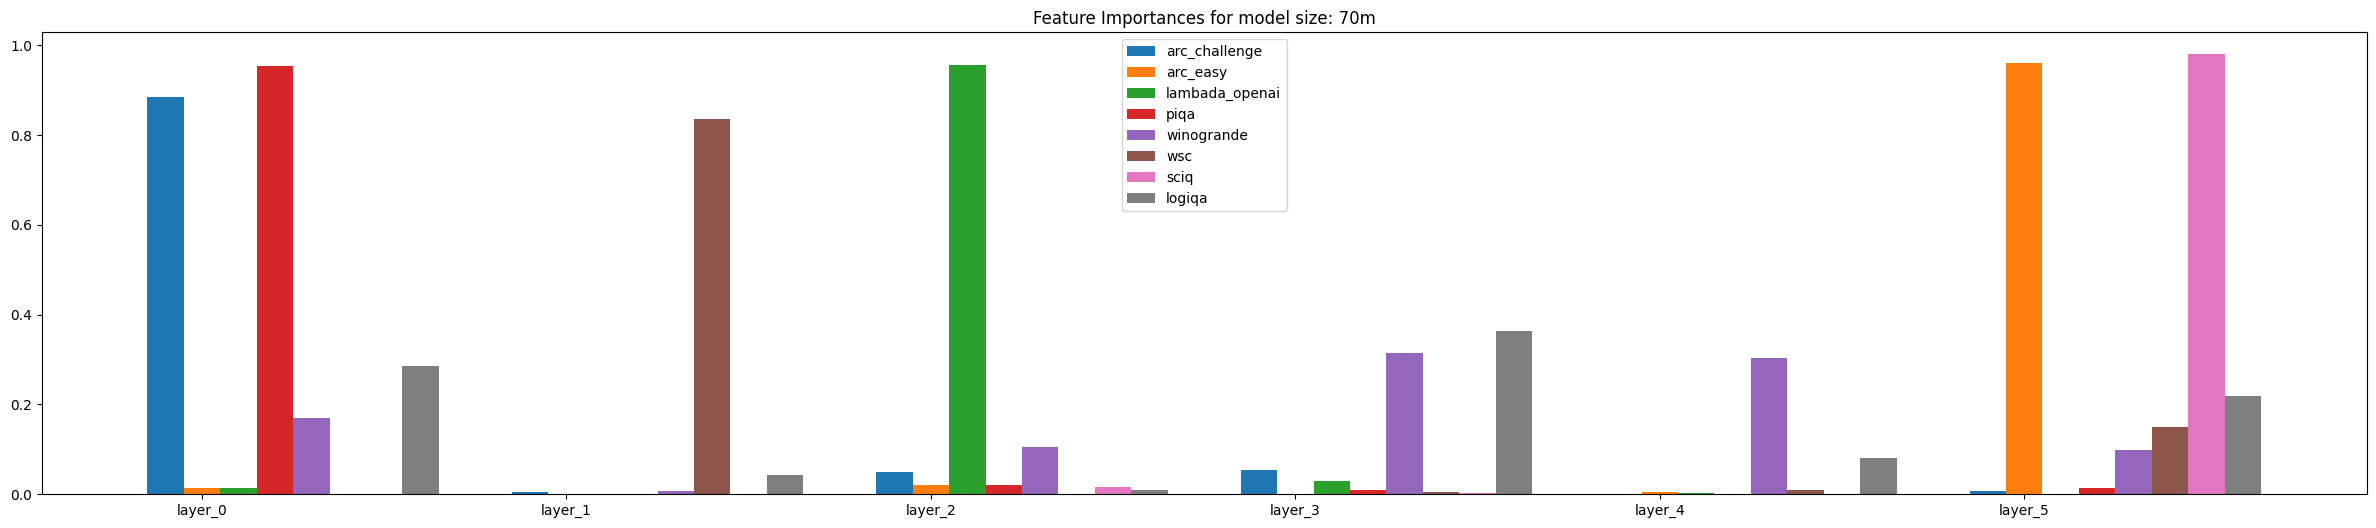

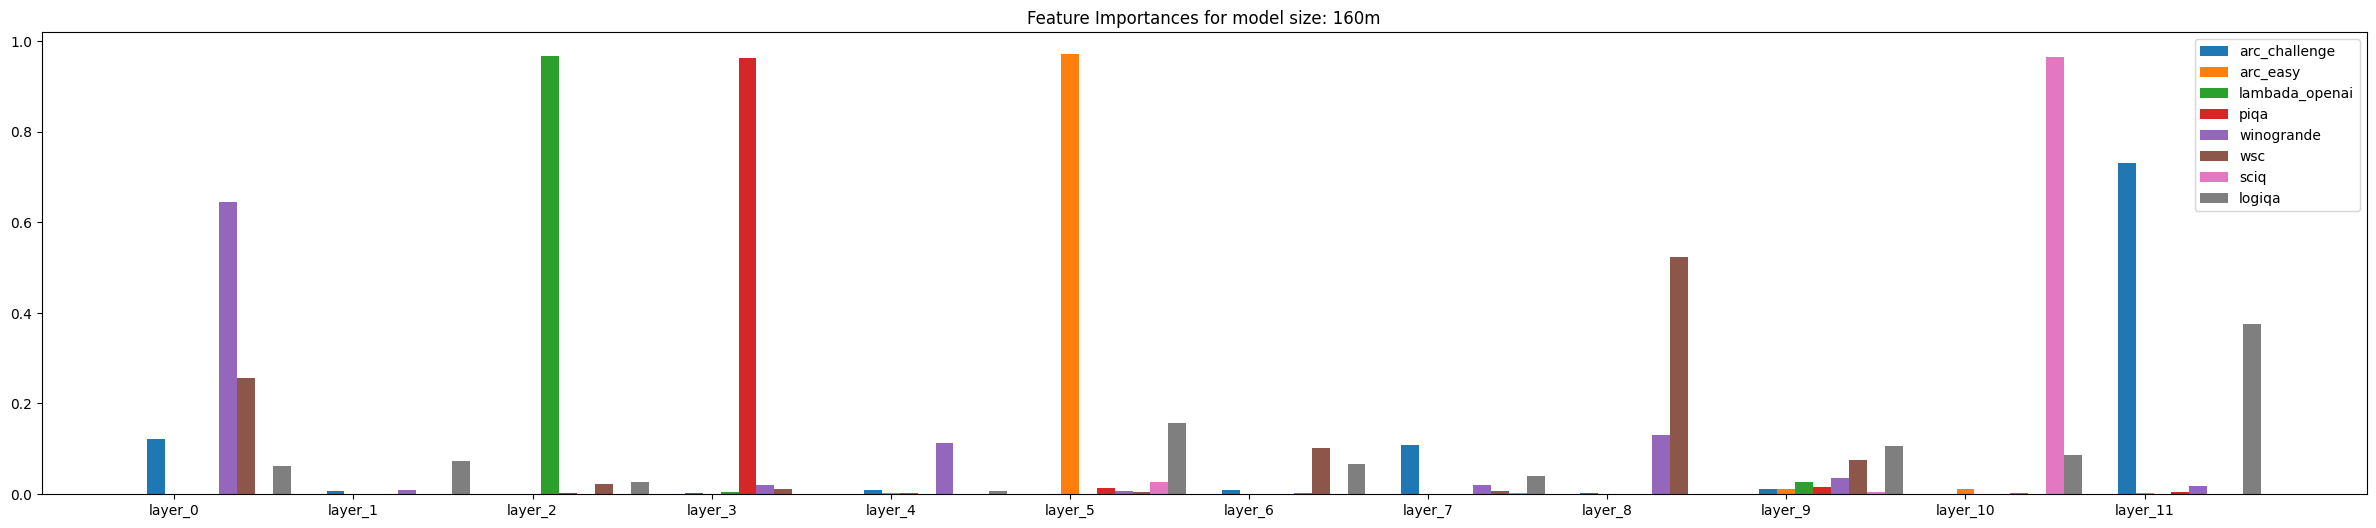

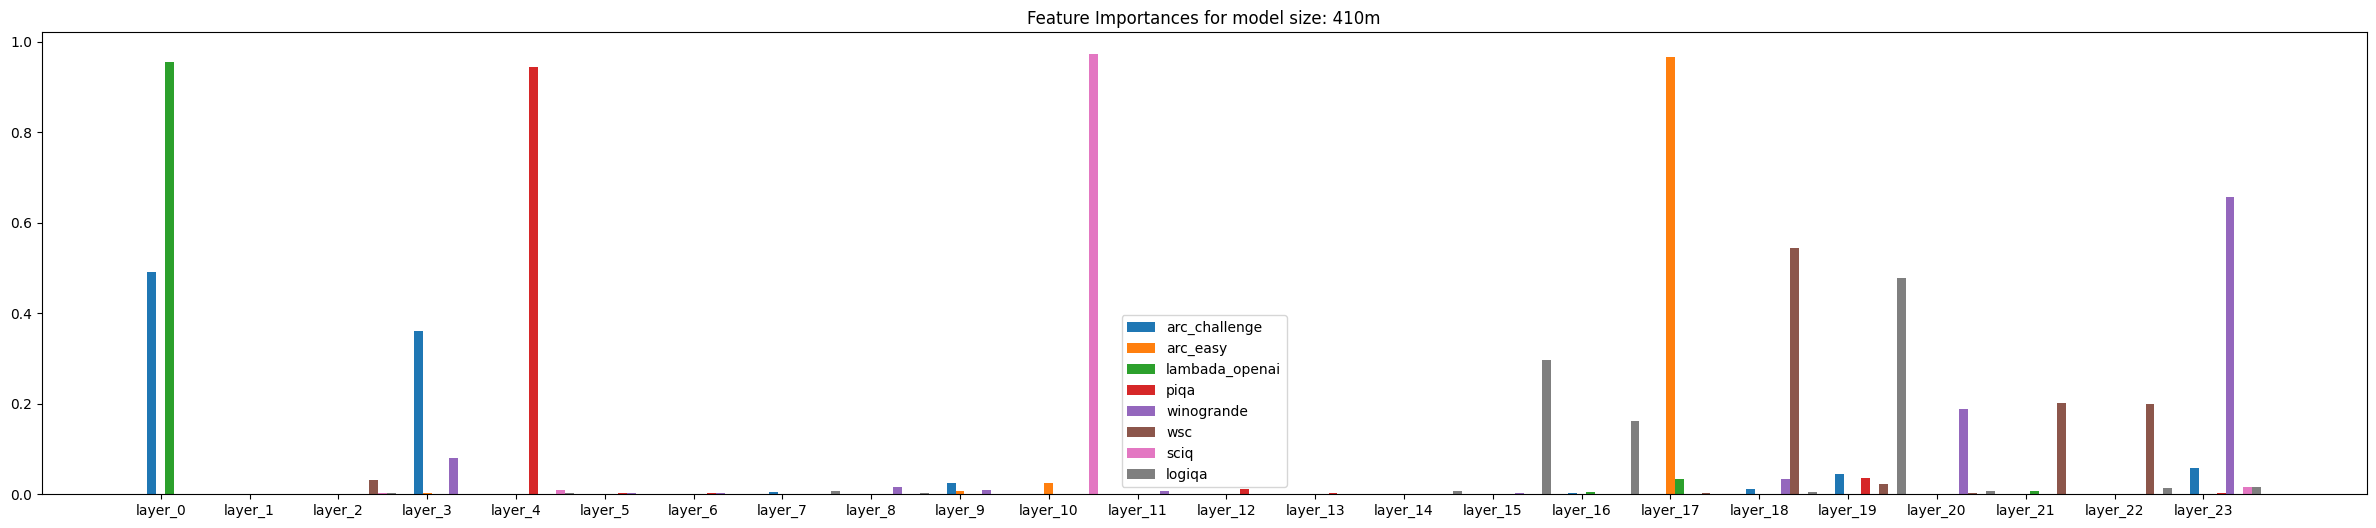

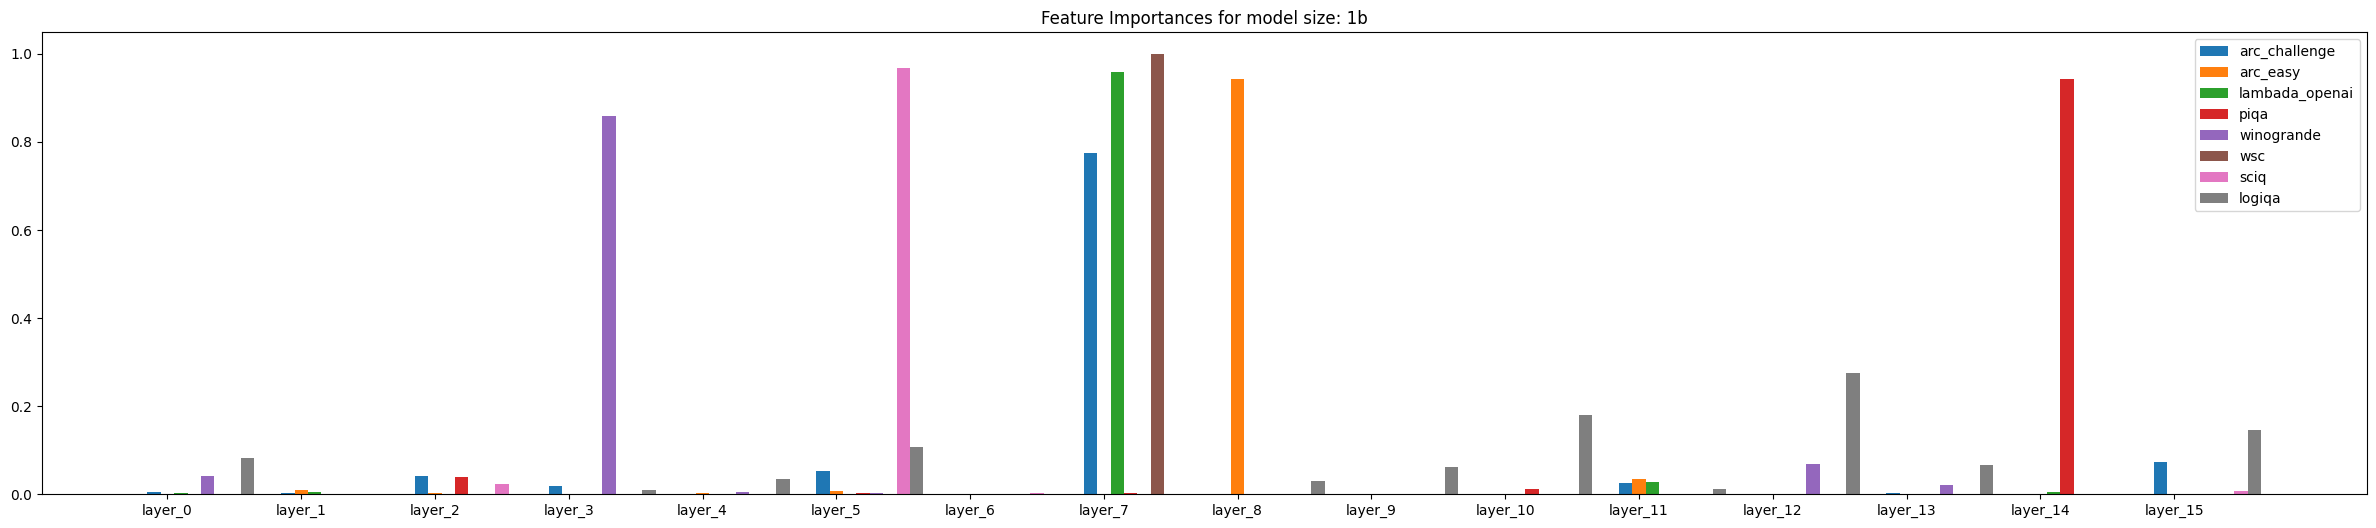

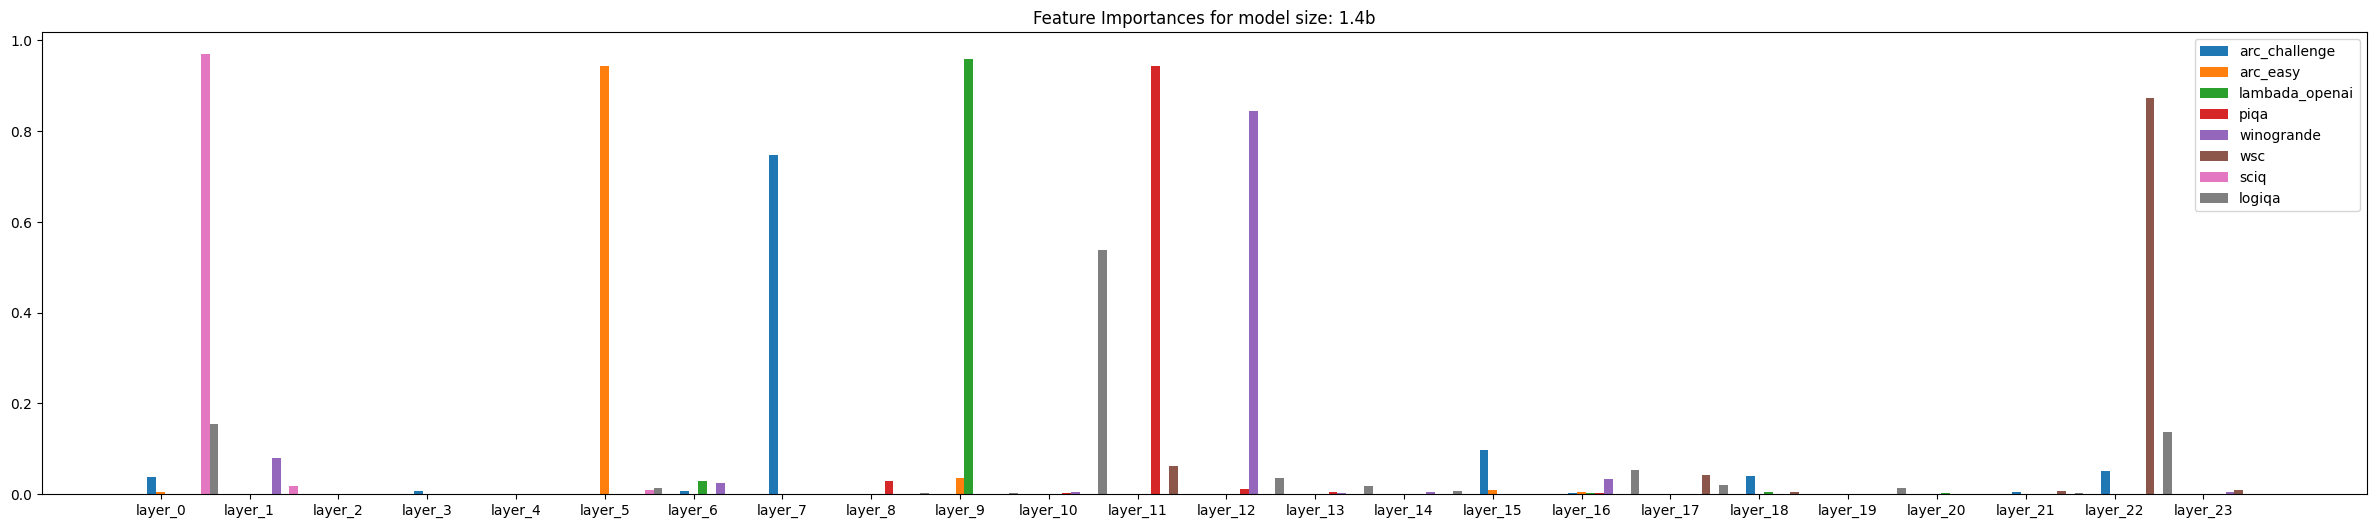

In [37]:
import numpy as np 

# plot the feature importance for each model size
for model_size, feature_importance_list in feature_importance.items():

    width = 0.1  # Increase the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(figsize=(30, 6))  # Increase the figsize to make the graph wider

    num_layers = len(feature_importance_list[0]['feature_importance'])

    x = np.arange(num_layers)

    for feature_importance_dict in feature_importance_list:
        eval_metric = feature_importance_dict['eval_metric']
        importance = feature_importance_dict['feature_importance']

        offset = width * multiplier

        _bar = ax.bar(offset + x, importance, width, label=eval_metric)

        multiplier += 1 
    
    ax.set_xticks(x + width, ["layer_" + str(i) for i in range(num_layers)]) 
    plt.legend()
    plt.title(f'Feature Importances for model size: {model_size}')
    plt.show()
    plt.close()

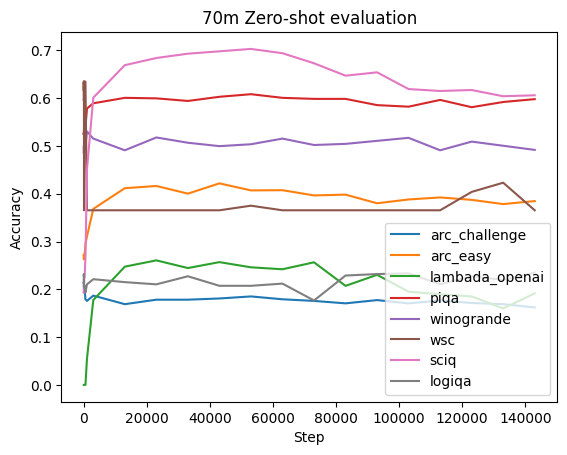

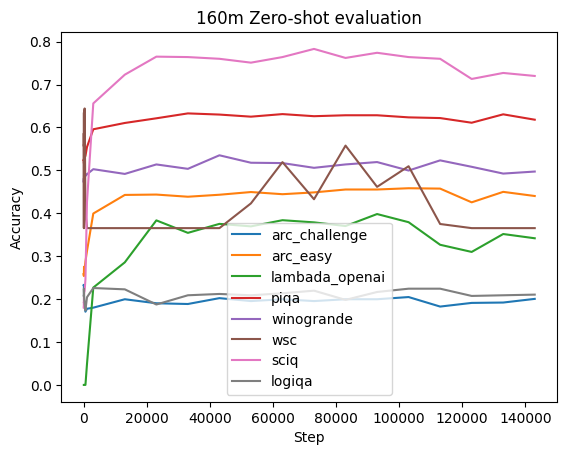

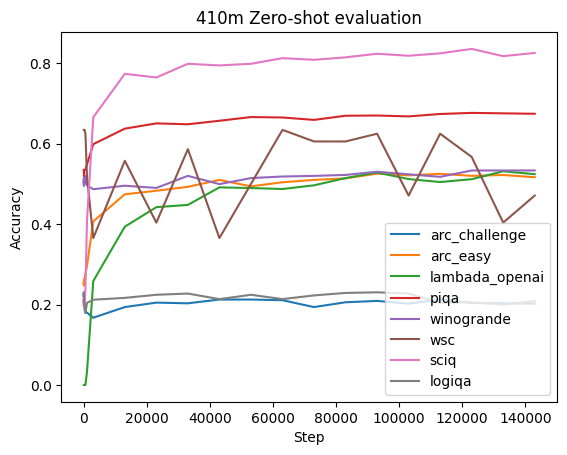

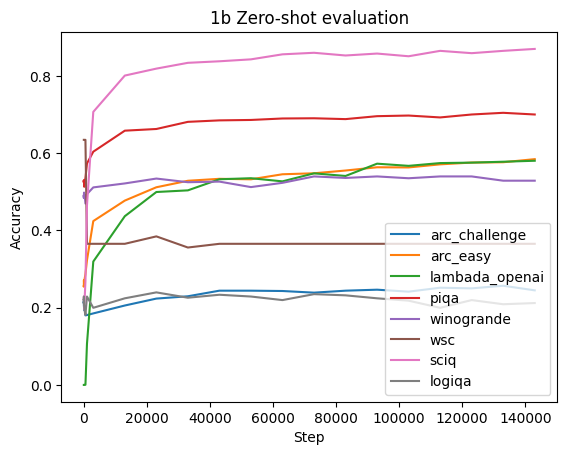

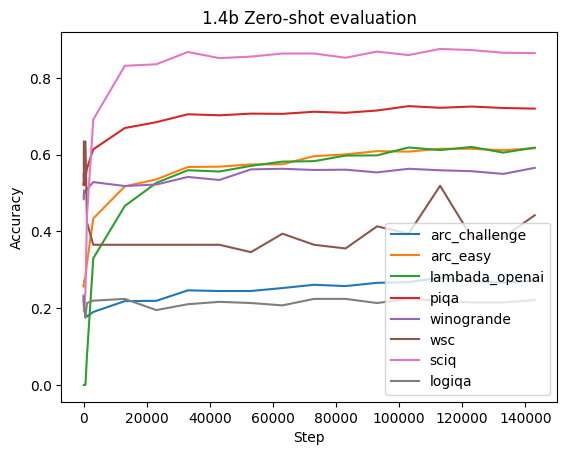

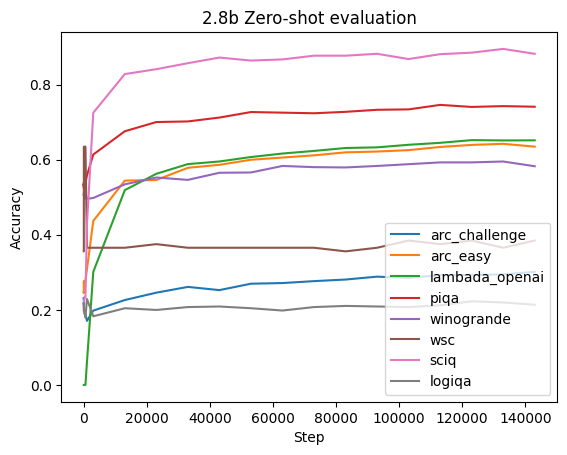

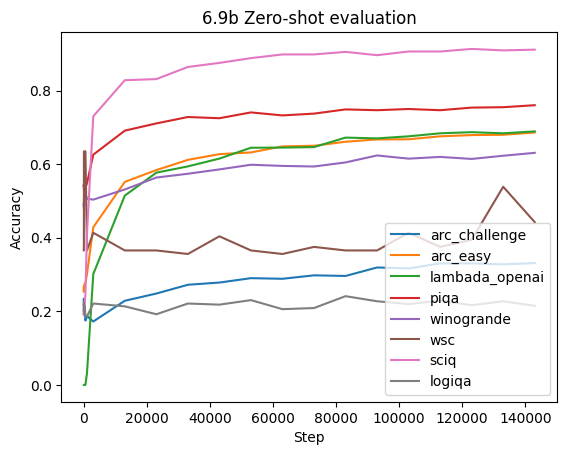

In [45]:
# For plotting out the evaluation results 

model_sizes = ["70m", "160m", "410m", "1b", "1.4b", "2.8b", "6.9b"]

for model_size in model_sizes:
    checkpoint_evals = get_checkpoint_evals(model_size)

    plt.figure()
    for eval_metric in EVAL_METRICS:
        plt.plot(checkpoint_evals.keys(), [checkpoint_evals[step][eval_metric] for step in checkpoint_evals.keys()], label=eval_metric)
    plt.legend()
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.title(f'{model_size} Zero-shot evaluation')

In [33]:
def plot_evals(checkpoint_evals):

    for eval_metric in EVAL_METRICS:
        plt.plot(checkpoint_evals.keys(), [checkpoint[eval_metric] for checkpoint in checkpoint_evals.values()], label=eval_metric)


In [ ]:
valid_step_numbers = [0,
    1,
    2,
    4,
    8,
    16,
    32,
    64,
    128,
    256,
    512,
    1000,
    3000,
    13000,
    23000,
    33000,
    43000,
    53000,
    63000,
    73000,
    83000,
    93000,
    103000,
    113000,
    123000,
    133000,
    143000]
